*Preparing Pandas dataframe*

In [188]:
import pandas as pd
import helper_functions as helper

dengue_df = pd.read_csv("ddo_dengue_data.csv")

# dengue_df = dengue_df.drop(labels='Baranggay', axis=1)
dengue_df = dengue_df.drop(labels='Month', axis=1)
dengue_df = dengue_df.drop(labels='Year', axis=1)
dengue_df = dengue_df.drop(labels='Baranggay', axis=1)

# baranggay_transform, baranggay_dict = helper.transform_classifications(dengue_df['Baranggay'])
soil_type_transform, soil_type_dict = helper.transform_classifications(dengue_df['Soil Type'])
elevation_transform, elevation_dict = helper.transform_elevation(dengue_df['Elevation'])

dengue_df['Soil Type'] = soil_type_transform
dengue_df['Elevation'] = elevation_transform
# dengue_df['Baranggay'] = baranggay_transform
dengue_df['Dengue Cases'].value_counts()

# for i in range(len(dengue_df)):
#     if dengue_df['Dengue Cases'][i] == 0 :
#         dengue_df.drop(i, inplace=True)

dengue_df['Dengue Cases'].value_counts()
# dengue_df

Dengue Cases
0    10478
1      943
2      453
3      110
4       57
8       29
5       24
6       23
Name: count, dtype: int64

*Converting pandas dataframe to torch tensor*

In [189]:
import torch
from torch import nn

X = dengue_df.drop(labels='Dengue Cases', axis=1)
y = dengue_df['Dengue Cases']

X = torch.tensor(X.values).to(dtype=torch.float32)
y = torch.tensor(y.values).to(dtype=torch.float32)

*Split the dataset*

*Device agnostic code*

In [190]:
device = "mps" if torch.backends.mps.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else device
device

'mps'

*Creating the Neural Network*

In [191]:
class DengueCasesPredictorModel(nn.Module):
    def __init__(self, input_channels = 8, hidden_units = 10, output_shape = 1):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_channels, out_features=hidden_units)
        self.layer_2 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer_3 = nn.Linear(in_features=hidden_units, out_features=hidden_units)
        self.layer_4 = nn.Linear(in_features=hidden_units, out_features=output_shape)
        self.relu = nn.ReLU()

    def forward(self, x: torch.Tensor):
        x = self.layer_1(x)
        x = self.relu(x)
        x = self.layer_2(x)
        # x = self.relu(x)
        x = self.layer_3(x)
        x = self.relu(x)
        x = self.layer_4(x)

        return x

In [193]:
from sklearn.model_selection import train_test_split
RANDOM_SEED = 42

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 0.2 = 20% of data will be test & 80% will be train
                                                    random_state=RANDOM_SEED)



In [194]:
from pathlib import Path

# model_path = Path('models/dengue_model.pth')

model = DengueCasesPredictorModel()
# model.load_state_dict(torch.load(model_path))
model.to(device)

DengueCasesPredictorModel(
  (layer_1): Linear(in_features=8, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.00000001)

In [214]:
def train_step(model: nn.Module, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, X, y):
    model.train()

    y_preds = model(X)
    loss = loss_fn(y_preds, y)

    # print(loss)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Train loss: {loss}")

    return y_preds

In [215]:
def test_step(model: nn.Module, loss_fn: nn.Module, X, y):
    model.eval()

    with torch.inference_mode():
        test_pred = model(X)
        test_loss = loss_fn(test_pred, y)

    print(f"Test loss: {test_loss}")
    return test_pred

In [198]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

torch.Size([1, 1311, 8])

In [223]:
epochs = 5000

train_losses = []
test_losses = []
train_preds = -1
test_preds = -1

for epoch in range(epochs):
    print(f"Epoch: {epoch}")
    train_preds = train_step(model, loss_fn, optimizer, X_train, y_train)
    test_preds = test_step(model, loss_fn, X_test, y_test)
    print("----------------------")

train_preds = train_preds * 100


Epoch: 0


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([9693])) that is different to the input size (torch.Size([9693, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 1
Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 2


/opt/anaconda3/lib/python3.11/site-packages/torch/nn/modules/loss.py:101: UserWarning: Using a target size (torch.Size([2424])) that is different to the input size (torch.Size([2424, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(input, target, reduction=self.reduction)


Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 3
Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 4
Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 5
Train loss: 0.24176907539367676
Test loss: 0.24749872088432312
----------------------
Epoch: 6
Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 7
Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 8
Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 9
Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 10
Train loss: 0.24176910519599915
Test loss: 0.24749873578548431
----------------------
Epoch: 11
Train loss: 0.24176910519599915
Test loss: 0.24749872088432312
----------------------
Epoch: 12
Train loss: 0.24176910519599915
Test loss: 0.24

Text(0.5, 1.0, 'Train preds')

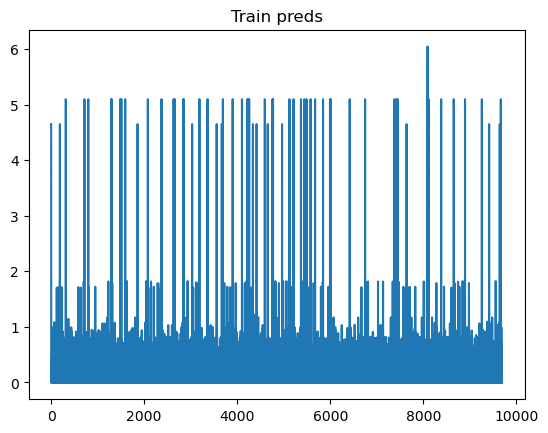

In [224]:
import matplotlib.pyplot as plt

relu_fn = nn.ReLU()

# train_preds = relu_fn(train_preds * 100)

np_train_preds = [data.cpu().detach().numpy() for data in relu_fn(train_preds)]
np_train_actual = [data.cpu().detach().numpy() for data in y_train]
np_test_preds = [data.cpu().detach().numpy() for data in relu_fn(test_preds)]
np_test_actual = [data.cpu().detach().numpy() for data in y_test]


plt.plot(range(len(np_train_preds)), np_train_preds)
# plt.plot(range(len(np_train_actual)), np_train_actual)
plt.title("Train preds")

Text(0.5, 1.0, 'Train actual')

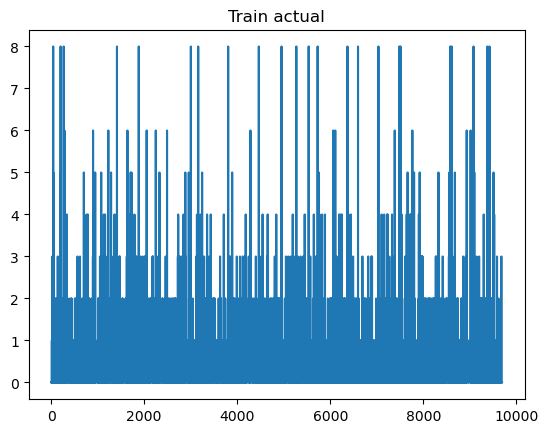

In [222]:
plt.plot(range(len(np_train_actual)), np_train_actual)
plt.title("Train actual")

Text(0.5, 1.0, 'Test preds')

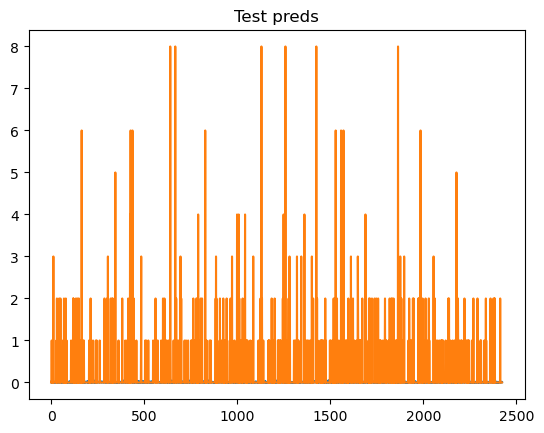

In [202]:
plt.plot(range(len(np_test_preds)), np_test_preds)
plt.plot(range(len(np_test_actual)), np_test_actual)
plt.title("Test preds")

Text(0.5, 1.0, 'Test actual')

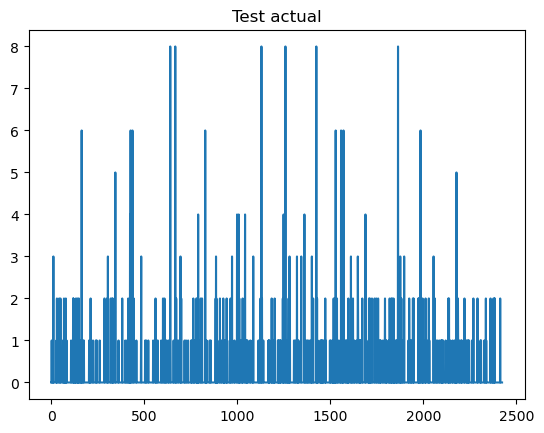

In [39]:
plt.plot(range(len(np_test_actual)), np_test_actual)
plt.title("Test actual")

ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

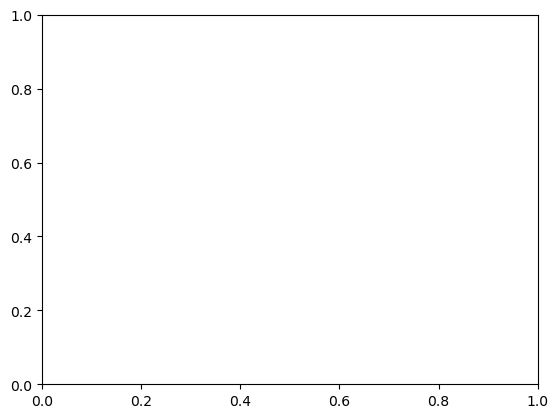

In [105]:
import matplotlib.pyplot as plt

np_train_losses = [data.cpu().detach().numpy() for data in train_losses]


plt.plot(range(100), np_train_losses)
plt.title("Train")

In [ ]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "dengue_model2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Sve the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to: models/dengue_model.pth


Text(0.5, 1.0, 'Test loss')

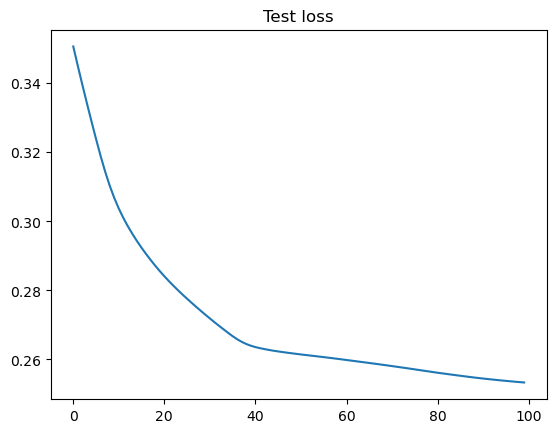

In [72]:
np_test_losses = [data.cpu().detach().numpy() for data in test_losses]
plt.plot(range(100), np_test_losses)
plt.title("Test loss")
